# **Image Enhancing: Denoise with Convolutional Autoencoder**

Data: google landmark dataset, subset, 11k images, source https://www.kaggle.com/google/google-landmarks-dataset

Model: convoluational autoencoder, lr=0.001, 30 epochs

Input images: original images 300x300x3, randomly cropped to 256x256x3, applied random noise for this test

Decoded/enhanced images are compare to input images

In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
#import pydot
import os
import math, time, random, datetime


import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

import cv2

#keras = tf.keras

#from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Cropping2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping

#import tensorflow_datasets as tfds
#from tensorflow.keras.datasets import cifar10
from google.colab import files

2.1.0-rc1


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [0]:
# RAM
#!cat /proc/meminfo

# CPU
#!cat /proc/cpuinfo

In [0]:
#from google.colab import drive

#drive.mount('/content/gdrive')

## load input dataset and create nosiy data


In [0]:
df = pd.read_csv('/content/s3x3_10k/train2_s3x3_list.csv')
dft = pd.read_csv('/content/s3x3_10k/test_s3x3_list.csv')
dft2 = pd.read_csv('/content/s3x3_10k/test2_s3x3_list.csv')
dft.head()

In [0]:
len(dft2.index)

6

In [0]:
HEIGHT = 256
WIDTH = 256
target_size = 300
CHAN = 3
batch_size = 100
test_bs = len(dft.index)
test2_bs = len(dft2.index)

drive = '/content/s3x3_10k/'

datagen = ImageDataGenerator(
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True,
    #channel_shift_range=25.,
    rescale=1./255
        )

datagen_test = ImageDataGenerator(
        rescale=1./255
        )

train_gen = datagen.flow_from_dataframe(dataframe=df[:10000],
                                        directory='/content/s3x3_10k/train2/',
                                        x_col='image',
                                        target_size=(target_size, target_size), 
                                        batch_size=batch_size, 
                                        class_mode=None,
                                        shuffle=True,
                                        seed=42)


val_gen = datagen_test.flow_from_dataframe(dataframe=df[10000:11000],
                                        directory='/content/s3x3_10k/train2/',
                                        x_col='image',
                                        target_size=(target_size, target_size), 
                                        batch_size=batch_size, 
                                        class_mode=None,
                                        shuffle=False)

test_gen = datagen_test.flow_from_dataframe(dataframe=dft[:],
                                        directory='/content/s3x3_10k/test/',
                                        x_col='image',
                                        target_size=(target_size, target_size), 
                                        batch_size=test_bs, 
                                        class_mode=None,
                                        shuffle=False)

test20_gen = datagen_test.flow_from_dataframe(dataframe=dft2[:],
                                        directory='/content/s3x3_10k/test/',
                                        x_col='image_0',
                                        target_size=(target_size, target_size), 
                                        batch_size=test2_bs, 
                                        class_mode=None,
                                        shuffle=False)


train_gen.n

Found 10000 validated image filenames.
Found 1000 validated image filenames.
Found 6 validated image filenames.
Found 6 validated image filenames.


10000

In [0]:
def image_crop(image, crop_size, crop_type='r'):  # center crop
    image=np.asarray(image)
    (crop_dh, crop_dw) = crop_size 
    if crop_type=='c':
      h = (image.shape[0] - crop_dh)//2
      w = (image.shape[1] - crop_dw)//2
    elif crop_type=='r':
      h = random.randint(0, image.shape[0] - crop_dh) 
      w = random.randint(0, image.shape[1] - crop_dw) 
    return image[h:h+crop_dh, w:w+crop_dw,:]



def crop_generator(batches, crop_size, crop_type='r'):
    (crop_dh, crop_dw) = crop_size
    while True:
        batch = next(batches)
        batch_crops = np.zeros((batch.shape[0], crop_dh, crop_dw, CHAN))
        for i in range(batch.shape[0]):
            batch_crops[i] = image_crop(batch[i], crop_size, crop_type)
        yield (batch_crops)


In [0]:
# 


def noise_generator(generator, ks=5, amp=0.05):
    
    for batch in generator:
     #  noise_batch = blur(batch,ks,'Average')
       noise_batch = (batch + amp*np.random.normal(loc=0.0, scale=1.0, size=batch.shape)).clip(0.,.999)
       yield (noise_batch, batch)


def comb_generator(gen1, gen2):
    for batch1, batch2 in zip(gen1, gen2):
      yield (batch1, batch2)

In [0]:


#crop and generate nosiy images
random.seed(42) 
cs = (HEIGHT, WIDTH)

train_in_gen = noise_generator(crop_generator(train_gen,cs,'r'))
val_in_gen = noise_generator(crop_generator(val_gen,cs,'c'))
test_in_gen = noise_generator(crop_generator(test_gen,cs,'c'),amp=0.07)
test2_in_gen = noise_generator(crop_generator(test20_gen,cs,'c'),amp=.05)
#test2_in_gen = comb_generator(test21_gen, test20_gen)

# display test images
test_n = test_gen.n
test_steps = 1
test_gen.reset()
test_images_noisy=np.vstack([next(test_in_gen)[0] for i in range(test_steps)])
test_gen.reset()
test_images=np.vstack([next(test_in_gen)[1] for i in range(test_steps)])


test2_steps = 1
test20_gen.reset()
test2_images_noisy=np.vstack([next(test2_in_gen)[0] for i in range(test2_steps)])

test20_gen.reset()
test2_images=np.vstack([next(test2_in_gen)[1] for i in range(test2_steps)])

test2_images.shape

(6, 256, 256, 3)

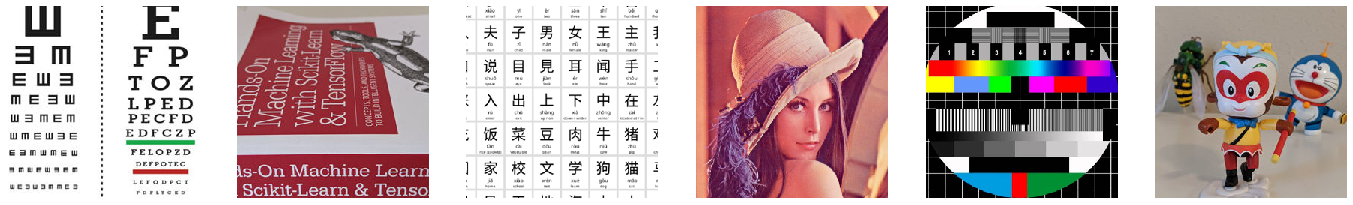

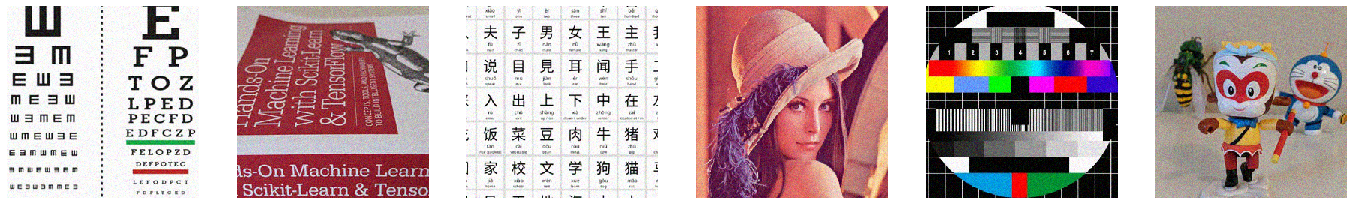

In [0]:
def plot_images(img, n0, dn):
  plt.figure(figsize=(24, 8))
  for i in range(n0,n0+dn):
   
    # display original + noise
    plt.subplot(1, 6, i+1-n0)
    plt.imshow(img[i,:,:].reshape(HEIGHT,WIDTH,CHAN).clip(.0,1.))
    plt.axis('off')

  plt.show()



n0=0
dn = 6
for n0 in range(0,test_gen.n,dn):
  plot_images(test2_images,n0,dn)
  plot_images(test2_images_noisy,n0,dn)

## autoencoder


In [0]:
def ssim(true_img, pred_img):
  return tf.reduce_mean(tf.image.ssim(true_img, pred_img))

In [0]:
REP = 1024

inputs = Input(shape=(HEIGHT,WIDTH,CHAN)) 

X = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
X = MaxPooling2D((2, 2), padding='same')(X)
#X = Conv2D(64, (3,3), activation='relu', padding='same')(X)
#X = MaxPooling2D((2, 2), padding='same')(X)
#X = Conv2D(128, (3,3), activation='relu', padding='same')(X)
X = Conv2D(64, (3,3), activation='relu', padding='same')(X)
#X = Flatten()(X)
#X = Dense(REP, activation='relu')(X)

#X = Dense(32*32*4, activation='relu')(X)
#X  = Reshape((64,64,64))(X)
X = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(X)
#X = Conv2DTranspose(128, (3,3), activation='relu', padding='same')(X)
#X = UpSampling2D((2, 2))(X)
#X = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(X)
X = UpSampling2D((2, 2))(X)
DEC = Conv2DTranspose(CHAN, (3,3), activation='linear', padding='same')(X)

autoencoder = Model(inputs, DEC)

autoencoder.compile(optimizer=Adam(), loss='mse') # loss=ssim, metrics=[ssim, 'accuracy'])

autoencoder.summary()

#tf.keras.utils.plot_model(autoencoder)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 3)       1731  

<h3>train model</h3>


In [0]:
lr0=0.001
annealer = LearningRateScheduler(lambda x: lr0 * .95 ** x) 
# 0.95^10=.60, ^20=.36, ^30=.21, ^40=.13

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

initial_epoch = 0
epochs = 30

steps_per_epoch = math.ceil(train_gen.n / batch_size)
validation_steps = math.ceil(val_gen.n / batch_size)

history=autoencoder.fit(train_in_gen, 
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=val_in_gen,
                                validation_steps=validation_steps,
                                initial_epoch=initial_epoch,
                                callbacks=[annealer, es]
                                   )  #, TensorBoard(log_dir='./logs', histogram_freq=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 10 steps
Epoch 1/30
100/100 [==============================] - 128s 1s/step - loss: 0.0132 - val_loss: 0.0022
Epoch 2/30
100/100 [==============================] - 129s 1s/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/30
100/100 [==============================] - 127s 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/30
100/100 [==============================] - 125s 1s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/30
100/100 [==============================] - 126s 1s/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/30
100/100 [==============================] - 125s 1s/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/30
100/100 [==============================] - 126s 1s/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/30
100/100 [==============================] - 125s 1s/step - loss: 9.8449e-04 - val_loss: 0.0010
Epoch 9/30
100/100 [==============================] - 125s 1s/step - loss: 9.5661e-04 - val_los

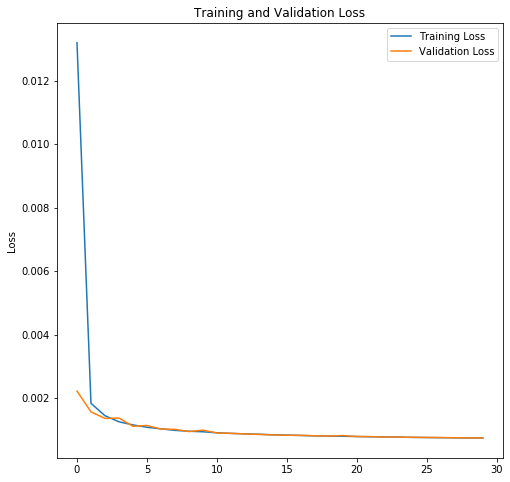

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.title('Training and Validation Loss')

plt.show()

In [0]:
gdrive_m="/content/models/"

#autoencoder.save(gdrive_m + "autoencoder_v3.4.1_glds3x3_noise.h5")

In [0]:
test_gen.reset()
test_images_output = autoencoder.predict(test_in_gen,
                              steps=test_steps,
                              verbose=1)

1/1 [==============================] - 0s 166ms/step


noisy images, amp=0.07


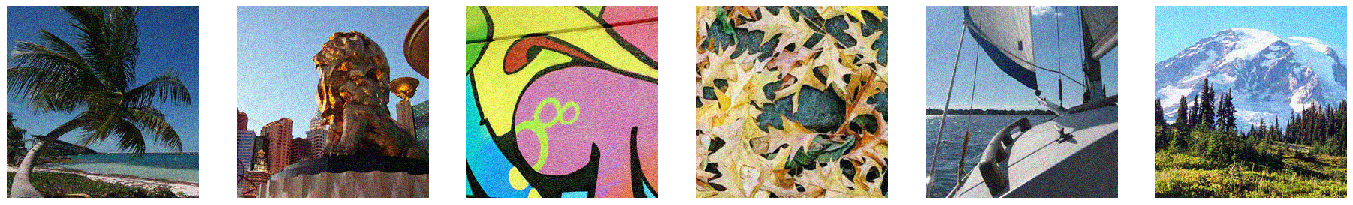


enhanced images


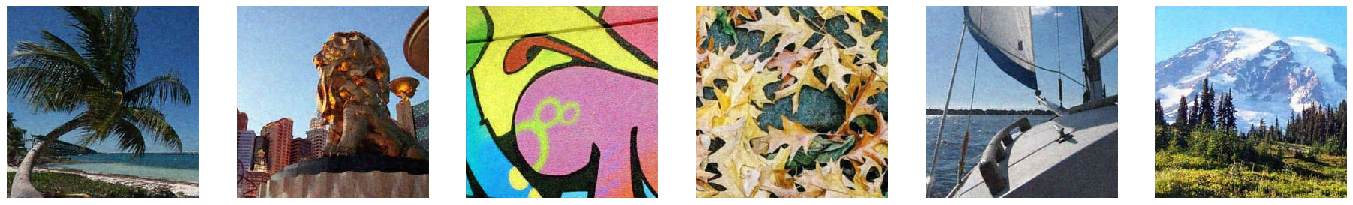


original images


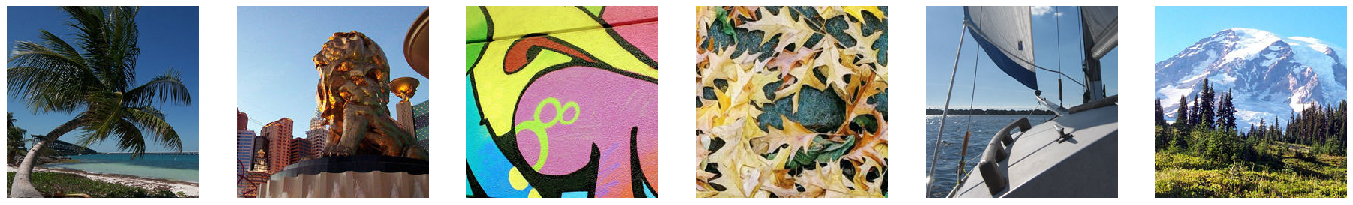

In [0]:
n0 = 0
dn = 6
for n0 in range(0,test_gen.n,dn):
  print("noisy images, amp=0.07")
  plot_images(test_images_noisy,n0,dn)
  print("\nenhanced images")
  plot_images(test_images_output,n0,dn)
  print("\noriginal images")
  plot_images(test_images,n0,dn)

In [0]:
test2_in_gen = noise_generator(crop_generator(test20_gen,cs,'c'),amp=.05)
test20_gen.reset()
test2_images_output = autoencoder.predict(test2_in_gen,
                              steps=test2_steps,
                              verbose=1)

1/1 [==============================] - 0s 15ms/step


noisy images, amp=0.05


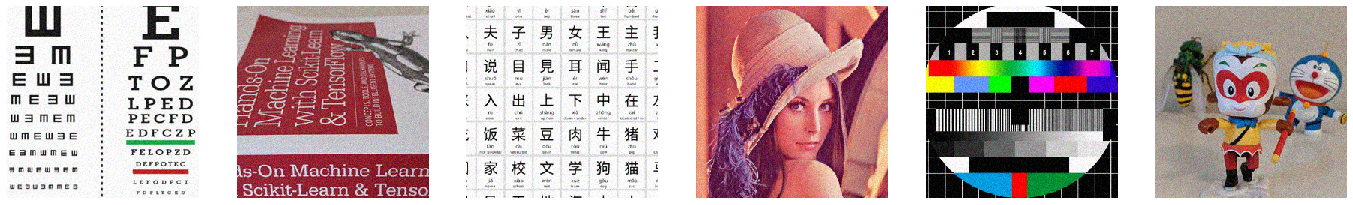


enhanced images


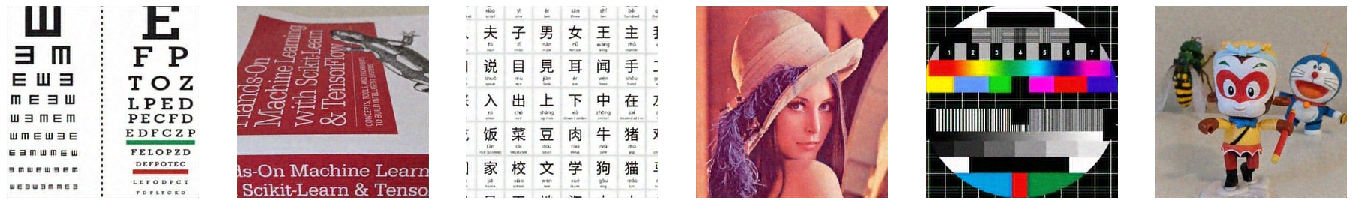


original images


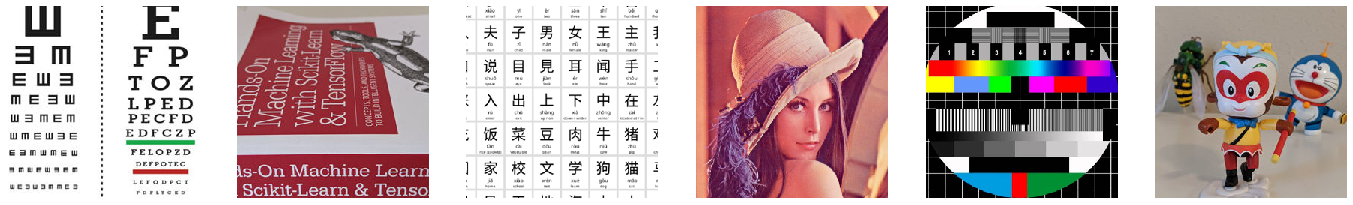

In [0]:
n0 = 0
dn = 6
for n0 in range(0,test20_gen.n,dn):
  print("noisy images, amp=0.05")
  plot_images(test2_images_noisy,n0,dn)
  print("\nenhanced images")
  plot_images(test2_images_output,n0,dn)
  print("\noriginal images")
  plot_images(test2_images,n0,dn)

## **Result**






# **References**


https://blog.keras.io/building-autoencoders-in-keras.html


